<br>

# Flu Shot Learning: Vaccination Prediction
----

This project is a solution to the Data Driven Flu Shot Learning challenge (https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/)

The premise of this project is as follows: 

Given a set of demographic information for a set of individuals, how accurately can I model wether a person will receive their H1N1 vaccine, their Seasonal Flu vaccine, or both?
 
-----

## Imports

In [578]:
#data manipulation
import numpy as np
import pandas as pd
from sklearn import preprocessing

#imputation
from sklearn.impute import SimpleImputer

#encoding 
import category_encoders as ce

#pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#feature selection
from sklearn.feature_selection import RFECV, RFE, SelectFromModel, SelectKBest, chi2

#models
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

#performance evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

#data analysis
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

## Read Data

In [394]:
training_set_labels = pd.read_csv('./training_set_labels.csv', index_col = 0)
training_set_features = pd.read_csv('./training_set_features.csv', index_col = 0)

In [248]:
training_set_features.head(1)

h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
respondent_id                                                            
0                       1.0             0.0                        0.0   

               behavioral_avoidance  behavioral_face_mask  \
respondent_id                                               
0                               0.0                   0.0   

               behavioral_wash_hands  behavioral_large_gatherings  \
respondent_id                                                       
0                                0.0                          0.0   

               behavioral_outside_home  behavioral_touch_face  \
respondent_id                                                   
0                                  1.0                    1.0   

               doctor_recc_h1n1  ...  income_poverty  marital_status  \
respondent_id                    ...                                   
0                           0.0  ...   Below Poverty     Not Married   

               rent_or_own   employment_status  hhs_geo_region  census_msa  \
respondent_id                                                                
0                      Own  Not in Labor Force        oxchjgsf     Non-MSA   

               household_adults  household_children  employment_industry  \
respondent_id                                                              
0                           0.0                 0.0                  NaN   

               employment_occupation  
respondent_id                         
0                                NaN  

[1 rows x 35 columns]

In [249]:
training_set_labels.head(1)

h1n1_vaccine  seasonal_vaccine
respondent_id                                
0                         0                 0

----------------

---------------

## EXPLORATORY DATA ANALYSIS

Resources : 
 1. https://www.datasciencecentral.com/profiles/blogs/quick-eda-article
 
 2. https://towardsdatascience.com/a-gentle-introduction-to-exploratory-data-analysis-f11d843b8184

-----------------

**Split the data into numerical and categorical types**

In [10]:
categorical_cols = training_set_features.select_dtypes(include = [object]).columns.to_list()
ordinal_cols = ['age_group', 'education', 'income_poverty']
nominal_cols = list(set(categorical_cols) - set(ordinal_cols))
numerical_cols = list(set(training_set_features.columns) - set(categorical_cols))

In [11]:
training_set_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [12]:
training_set_features.describe().T

count      mean       std  min  25%  50%  75%  \
h1n1_concern                 26615.0  1.618486  0.910311  0.0  1.0  2.0  2.0   
h1n1_knowledge               26591.0  1.262532  0.618149  0.0  1.0  1.0  2.0   
behavioral_antiviral_meds    26636.0  0.048844  0.215545  0.0  0.0  0.0  0.0   
behavioral_avoidance         26499.0  0.725612  0.446214  0.0  0.0  1.0  1.0   
behavioral_face_mask         26688.0  0.068982  0.253429  0.0  0.0  0.0  0.0   
behavioral_wash_hands        26665.0  0.825614  0.379448  0.0  1.0  1.0  1.0   
behavioral_large_gatherings  26620.0  0.358640  0.479610  0.0  0.0  0.0  1.0   
behavioral_outside_home      26625.0  0.337315  0.472802  0.0  0.0  0.0  1.0   
behavioral_touch_face        26579.0  0.677264  0.467531  0.0  0.0  1.0  1.0   
doctor_recc_h1n1             24547.0  0.220312  0.414466  0.0  0.0  0.0  0.0   
doctor_recc_seasonal         24547.0  0.329735  0.470126  0.0  0.0  0.0  1.0   
chronic_med_condition        25736.0  0.283261  0.450591  0.0  0.0  0.0  1.0   
child_under_6_months         25887.0  0.082590  0.275266  0.0  0.0  0.0  0.0   
health_worker                25903.0  0.111918  0.315271  0.0  0.0  0.0  0.0   
health_insurance             14433.0  0.879720  0.325300  0.0  1.0  1.0  1.0   
opinion_h1n1_vacc_effective  26316.0  3.850623  1.007436  1.0  3.0  4.0  5.0   
opinion_h1n1_risk            26319.0  2.342566  1.285539  1.0  1.0  2.0  4.0   
opinion_h1n1_sick_from_vacc  26312.0  2.357670  1.362766  1.0  1.0  2.0  4.0   
opinion_seas_vacc_effective  26245.0  4.025986  1.086565  1.0  4.0  4.0  5.0   
opinion_seas_risk            26193.0  2.719162  1.385055  1.0  2.0  2.0  4.0   
opinion_seas_sick_from_vacc  26170.0  2.118112  1.332950  1.0  1.0  2.0  4.0   
household_adults             26458.0  0.886499  0.753422  0.0  0.0  1.0  1.0   
household_children           26458.0  0.534583  0.928173  0.0  0.0  0.0  1.0   

                             max  
h1n1_concern                 3.0  
h1n1_knowledge               2.0  
behavioral_antiviral_meds    1.0  
behavioral_avoidance         1.0  
behavioral_face_mask         1.0  
behavioral_wash_hands        1.0  
behavioral_large_gatherings  1.0  
behavioral_outside_home      1.0  
behavioral_touch_face        1.0  
doctor_recc_h1n1             1.0  
doctor_recc_seasonal         1.0  
chronic_med_condition        1.0  
child_under_6_months         1.0  
health_worker                1.0  
health_insurance             1.0  
opinion_h1n1_vacc_effective  5.0  
opinion_h1n1_risk            5.0  
opinion_h1n1_sick_from_vacc  5.0  
opinion_seas_vacc_effective  5.0  
opinion_seas_risk            5.0  
opinion_seas_sick_from_vacc  5.0  
household_adults             3.0  
household_children           3.0

In [13]:
#What kind of data are we working with (ordinal, nominal)
#for col in non_float_cols:
for col in training_set_features.columns:
    print(col, '\n', training_set_features[col].unique(), '\n')

h1n1_concern 
 [ 1.  3.  2.  0. nan] 

h1n1_knowledge 
 [ 0.  2.  1. nan] 

behavioral_antiviral_meds 
 [ 0.  1. nan] 

behavioral_avoidance 
 [ 0.  1. nan] 

behavioral_face_mask 
 [ 0.  1. nan] 

behavioral_wash_hands 
 [ 0.  1. nan] 

behavioral_large_gatherings 
 [ 0.  1. nan] 

behavioral_outside_home 
 [ 1.  0. nan] 

behavioral_touch_face 
 [ 1.  0. nan] 

doctor_recc_h1n1 
 [ 0. nan  1.] 

doctor_recc_seasonal 
 [ 0. nan  1.] 

chronic_med_condition 
 [ 0.  1. nan] 

child_under_6_months 
 [ 0.  1. nan] 

health_worker 
 [ 0.  1. nan] 

health_insurance 
 [ 1. nan  0.] 

opinion_h1n1_vacc_effective 
 [ 3.  5.  4.  2.  1. nan] 

opinion_h1n1_risk 
 [ 1.  4.  3.  2.  5. nan] 

opinion_h1n1_sick_from_vacc 
 [ 2.  4.  1.  5.  3. nan] 

opinion_seas_vacc_effective 
 [ 2.  4.  5.  3.  1. nan] 

opinion_seas_risk 
 [ 1.  2.  4.  3.  5. nan] 

opinion_seas_sick_from_vacc 
 [ 2.  4.  1.  5. nan  3.] 

age_group 
 ['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Yea

## Distribution of Numerical Columns

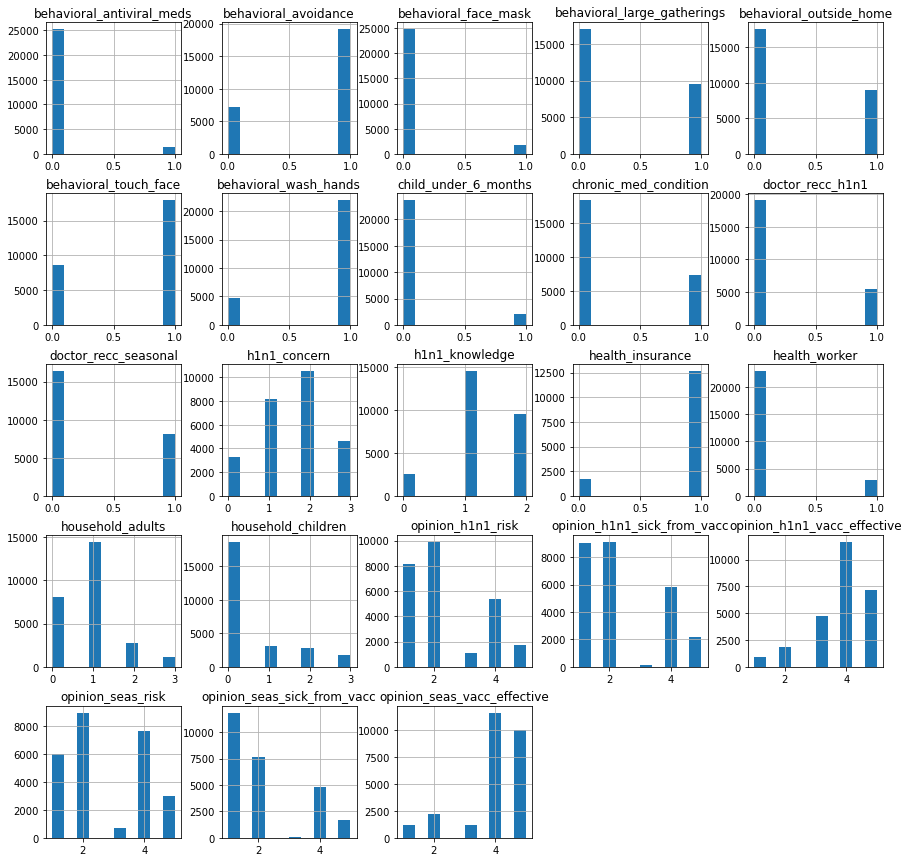

In [11]:
hist = training_set_features.hist(figsize = (15,15))

## Distribution of Categorical Columns

**A note on sampling:**
    
     The data has alot of samples for white people but is lacking 
    representation for other races. How will this affect prediction
    for vaccines for other races? I predict it will perform well when
    classifying white people, but generalize less well when the data
    point represents someone who isn't white. 

In [12]:
training_set_features_cat = training_set_features.select_dtypes(include = 'object').copy()

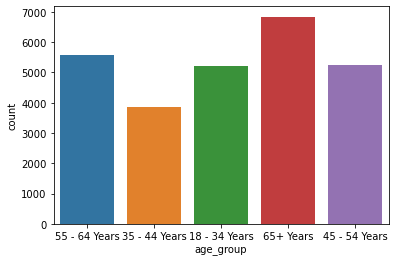

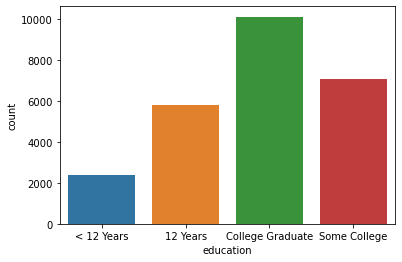

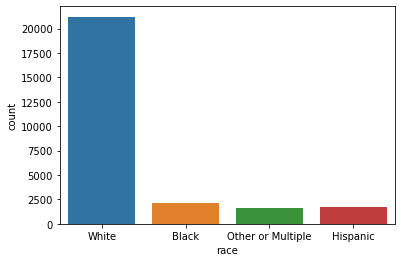

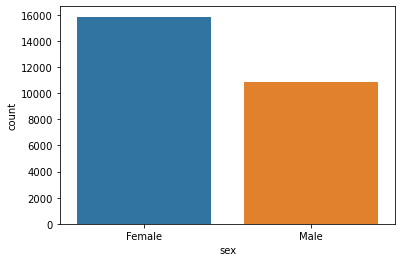

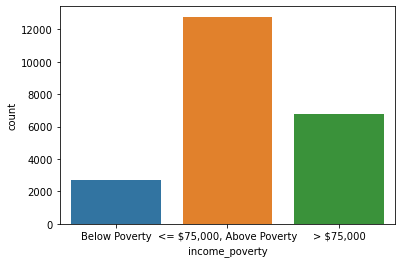

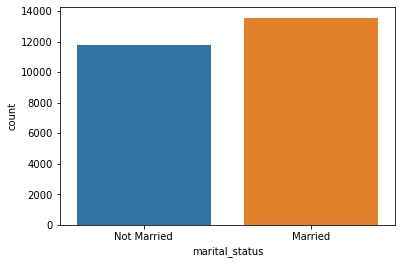

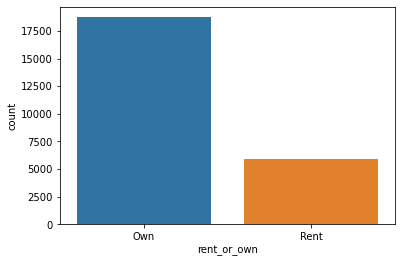

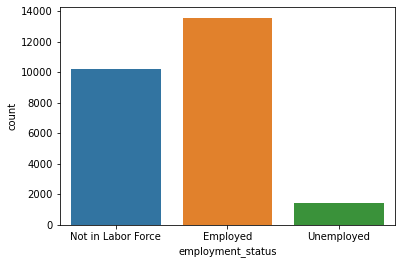

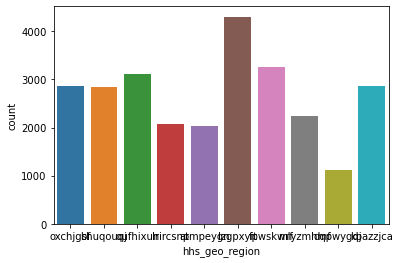

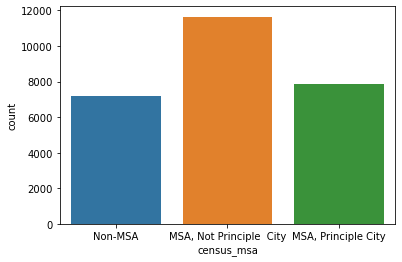

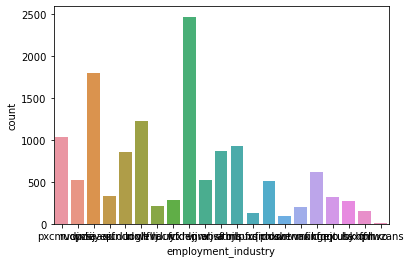

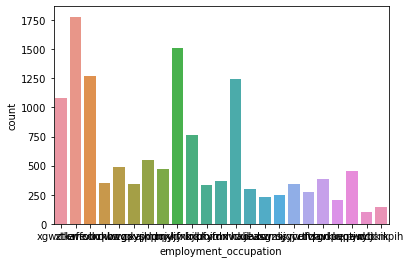

In [13]:
for i, col in enumerate(categorical_cols):
    plt.figure(i)
    sns.countplot(data = training_set_features_cat, x = col)

## Outlier Analysis

Resource: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

### Thoughts: 
This dataset doesn't really benefit from outlier analysis as the variables all take on disrete values of the type you would find in a survey. Nevertheless, it may be beneficial to see how outlier filtering affects prediction accuracy 

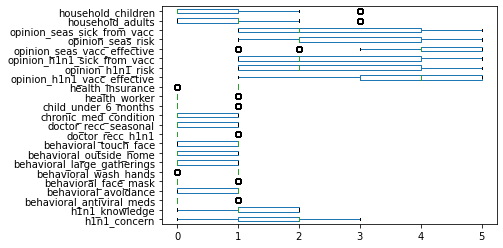

In [14]:
boxplot = training_set_features.boxplot(grid = False, vert = False)

In [15]:
#For baseline model, I will be removing rows with z-score > 3
threshold = 2.8
z_scores_numerical_cols = np.abs(stats.zscore(training_set_features[numerical_cols], nan_policy = 'omit'))
print('%d outliers / %d total rows  (%d%% of data)  calculated with threshold of %d' %(len(np.where(z_scores_numerical_cols>threshold)[0]), training_set_features[numerical_cols].shape[0] , (len(np.where(z_scores_numerical_cols>threshold)[0])/training_set_features[numerical_cols].shape[0]) * 100, threshold))

#remove rows with outliers from the dataframe
rows_to_keep = list(set(training_set_features.index) - set(np.where(z_scores_numerical_cols > threshold)[0]))
training_set_features_no_num_outliers = (training_set_features.loc[rows_to_keep])
training_set_labels_no_num_outliers = training_set_labels.loc[rows_to_keep]

10190 outliers / 26707 total rows  (38% of data)  calculated with threshold of 2


C:\Users\Yousef\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\Yousef\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [16]:
training_set_features_no_num_outliers_dropped = training_set_features_no_num_outliers.drop(columns = ['employment_industry', 'employment_occupation', 'health_insurance'])

## Data Relationships: Pearson Correlation

In [189]:
#add the labels to the feature dataframe
features_and_labels = pd.concat([training_set_features, training_set_labels], axis = 1, sort = False)

# TODO: 
Add the ordinal columns but after encoding them since they take on actual values

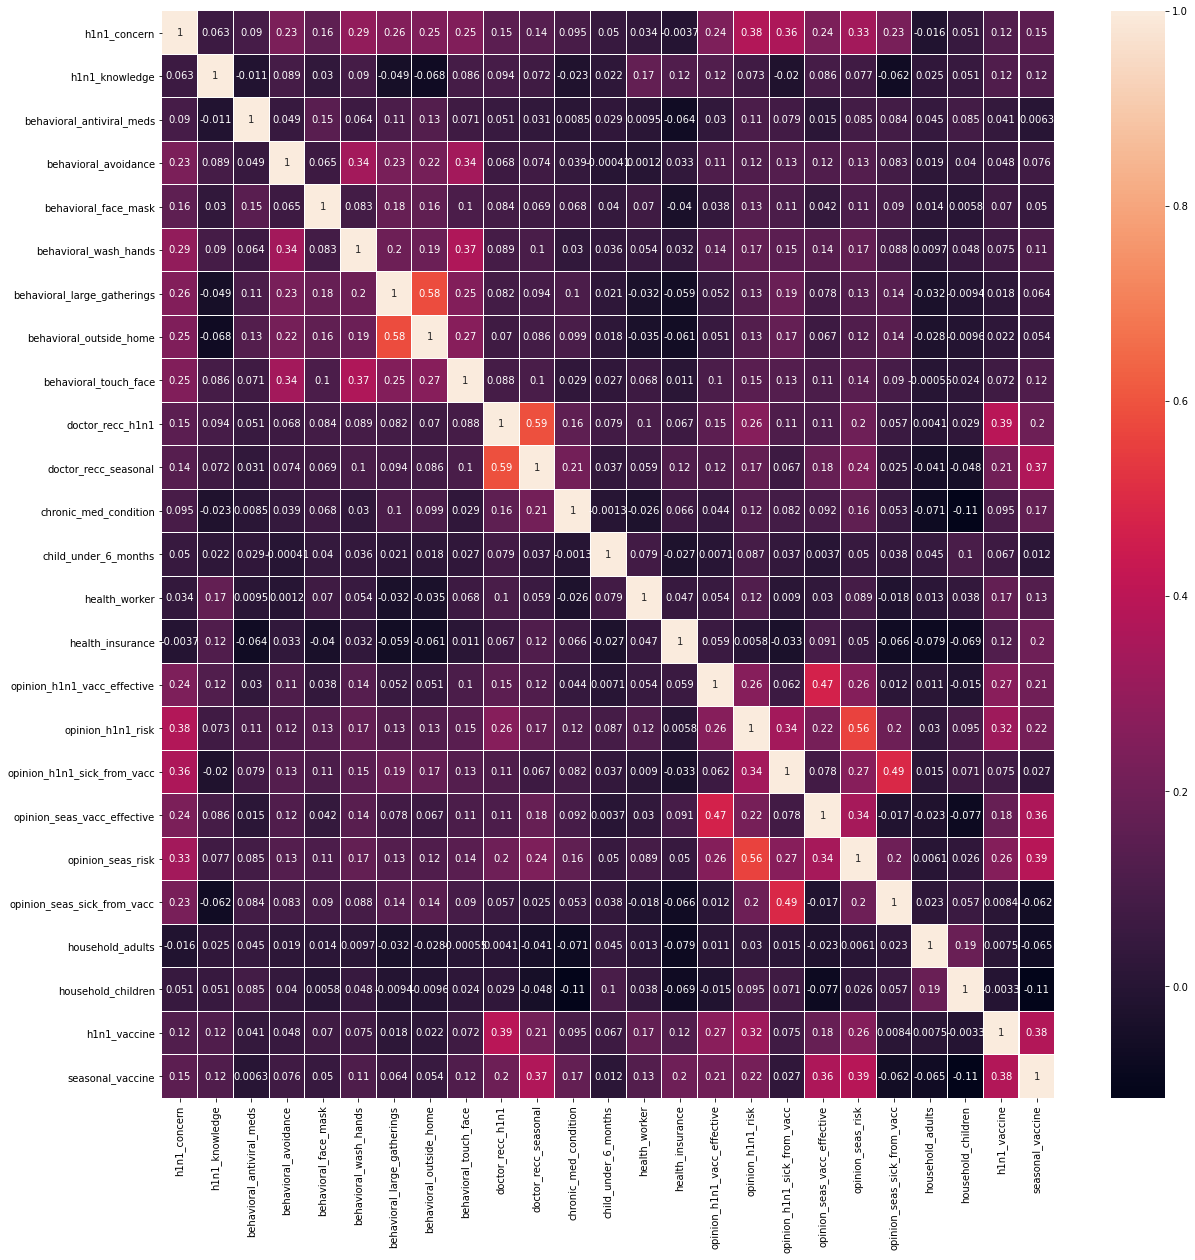

In [190]:
corr = features_and_labels.corr()
plt.figure(figsize = (20, 20))
sns.heatmap(corr, linewidths = .1, annot = True)

In [650]:
corr['h1n1_vaccine'][corr['h1n1_vaccine'] < 1]

h1n1_concern                   0.121929
h1n1_knowledge                 0.117951
behavioral_antiviral_meds      0.040608
behavioral_avoidance           0.047690
behavioral_face_mask           0.070498
behavioral_wash_hands          0.074712
behavioral_large_gatherings    0.017822
behavioral_outside_home        0.021768
behavioral_touch_face          0.071648
doctor_recc_h1n1               0.393890
doctor_recc_seasonal           0.209864
chronic_med_condition          0.095207
child_under_6_months           0.066962
health_worker                  0.169768
health_insurance               0.121170
opinion_h1n1_vacc_effective    0.269347
opinion_h1n1_risk              0.323265
opinion_h1n1_sick_from_vacc    0.075091
opinion_seas_vacc_effective    0.179272
opinion_seas_risk              0.258571
opinion_seas_sick_from_vacc    0.008360
household_adults               0.007545
household_children            -0.003320
seasonal_vaccine               0.377143
Name: h1n1_vaccine, dtype: float64

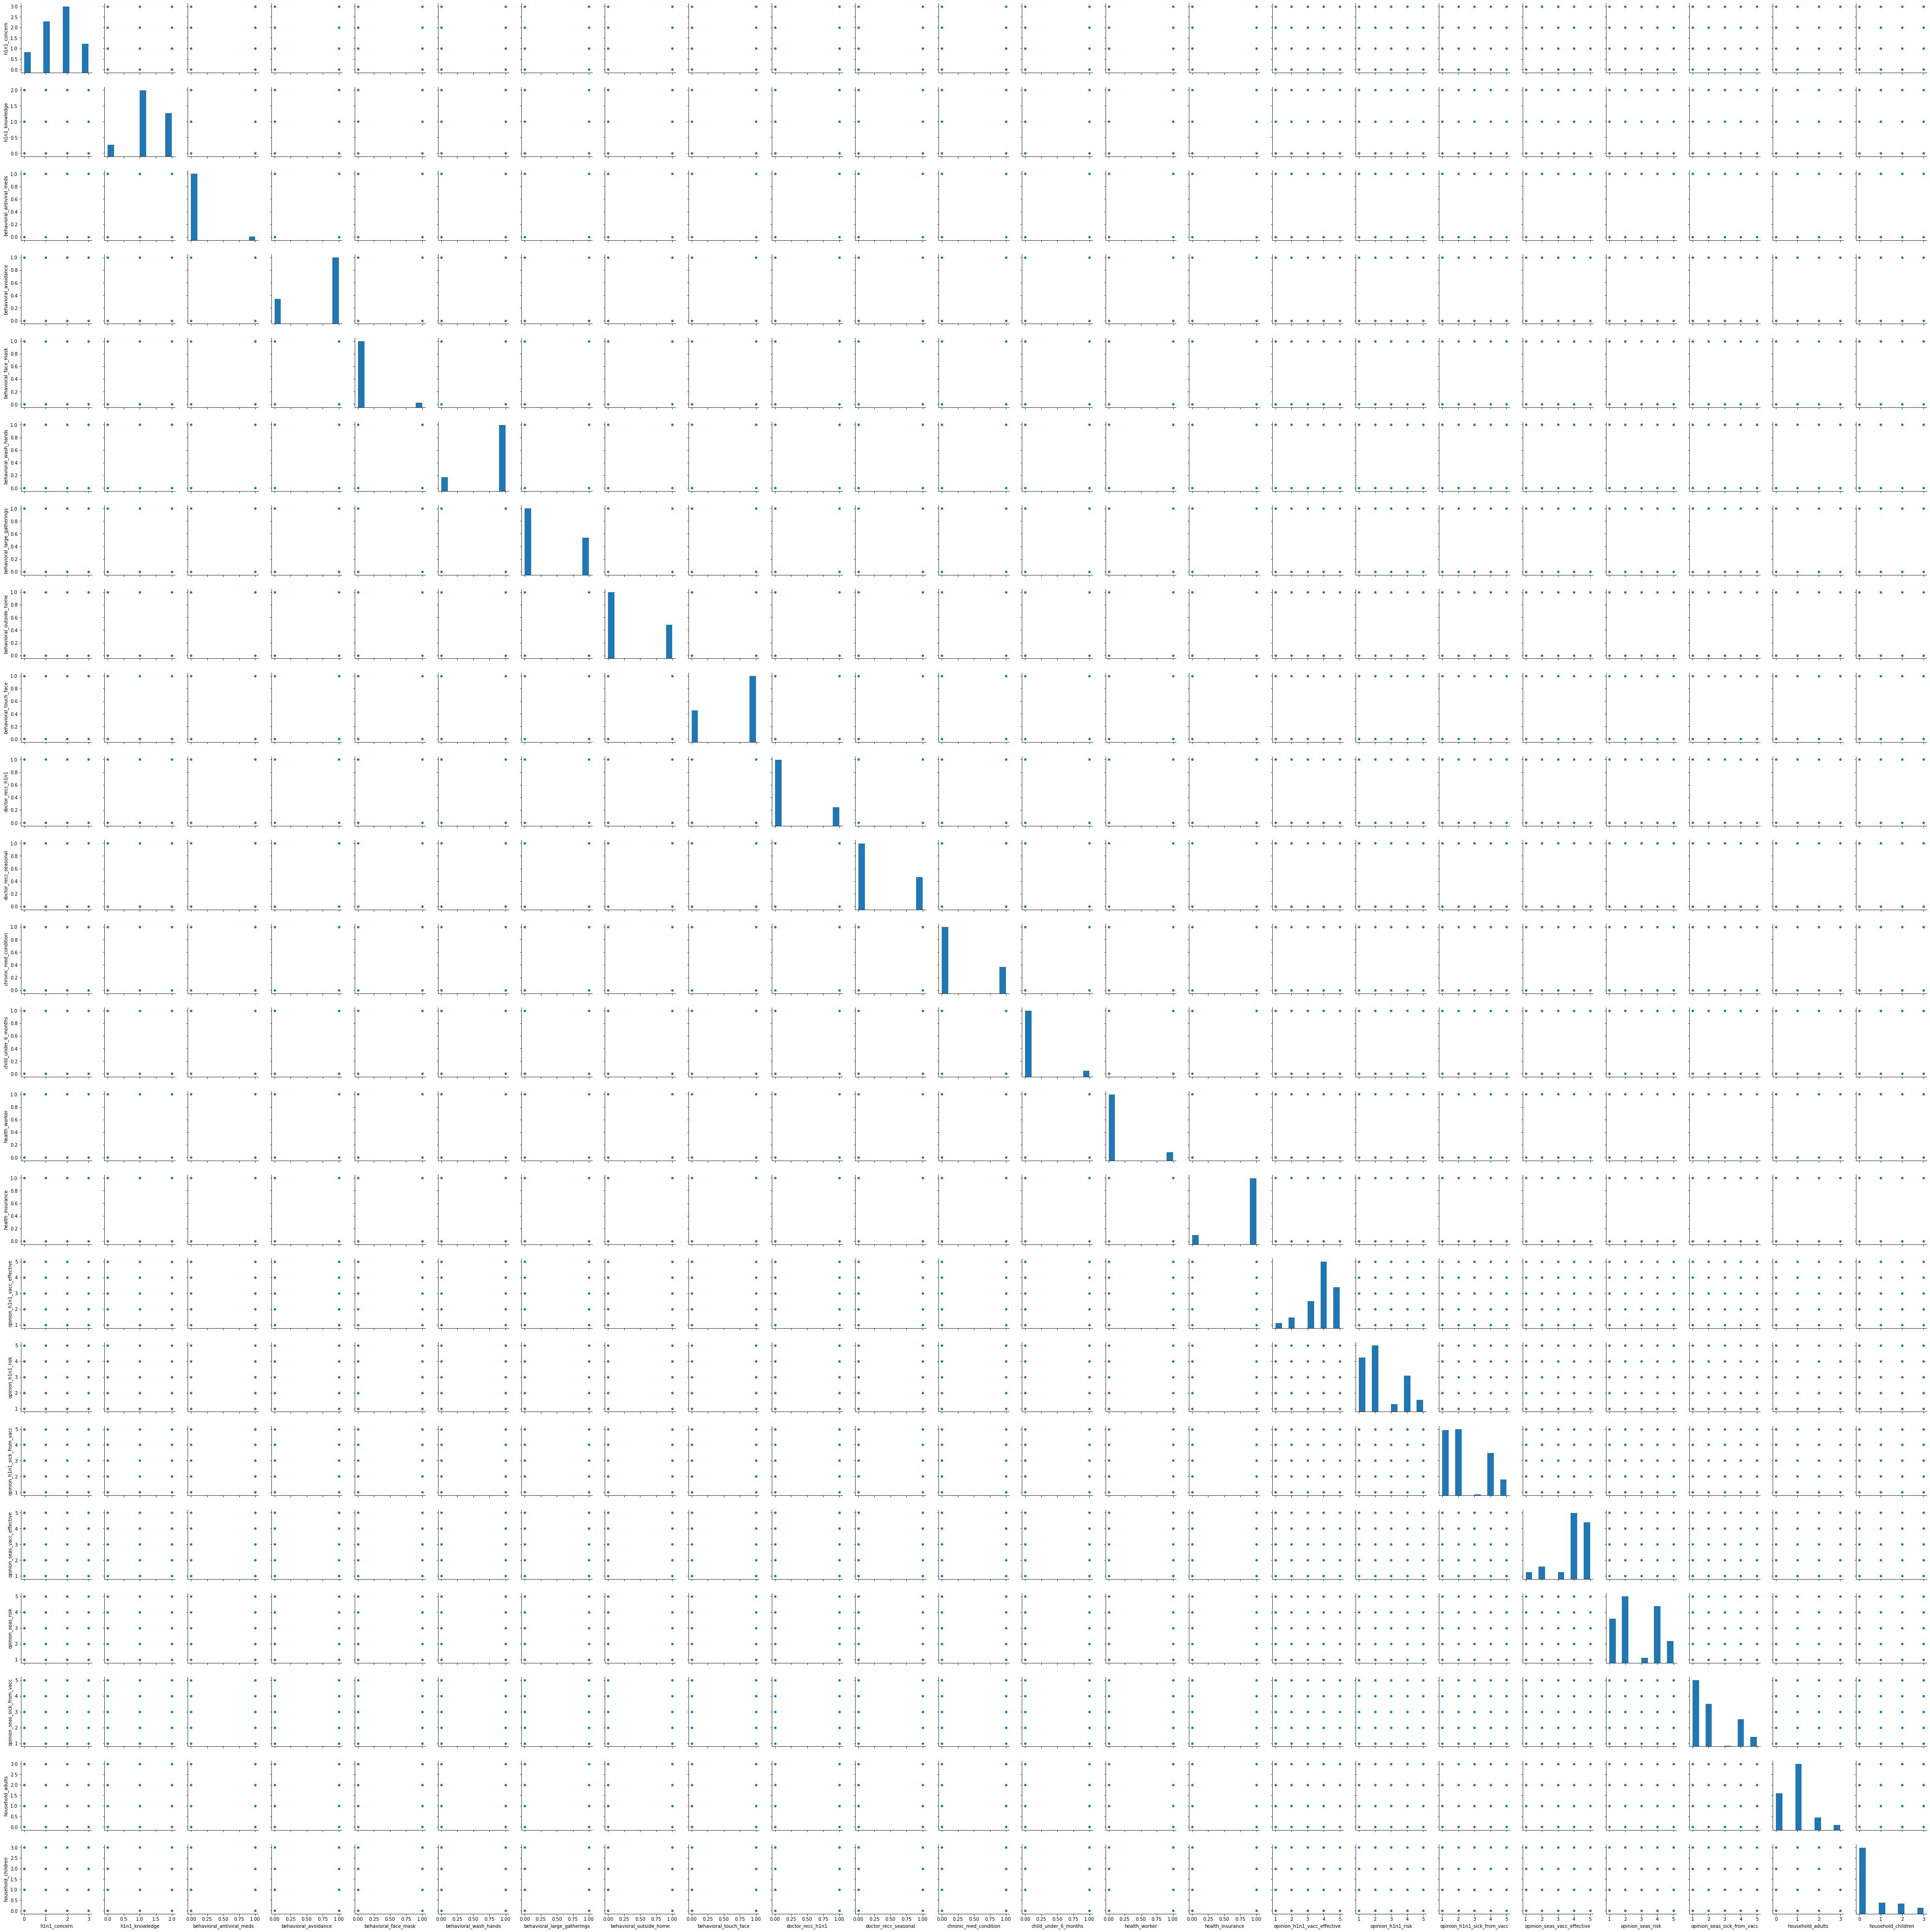

In [205]:
sns.pairplot(training_set_features)

In [466]:
#Select features based on correlation threshold
correlation_threshold = 0.06

#Get most relevant features for h1n1 vaccine 
corr_h1n1 = abs(corr['h1n1_vaccine'])
relevant_h1n1 = corr_h1n1[corr_h1n1 >= correlation_threshold].index.tolist()

#Get most relevant features for seas vaccine
corr_seas = abs(corr['seasonal_vaccine'])
relevant_seas = corr_seas[corr_seas >= correlation_threshold].index.tolist()

#Combine features and remove labels from features
relevant_features = set(relevant_h1n1) | set(relevant_seas)
relevant_features = list(relevant_features - {'h1n1_vaccine', 'seasonal_vaccine'})

print('%d / %d features chosen (%d%%)' %(len(relevant_features), corr.shape[0] - 2, (len(relevant_features)/(corr.shape[0] - 2))*100))

21 / 23 features chosen (91%)


In [21]:
dropped_columns = set(numerical_cols) - set(relevant_features)
dropped_columns

{'behavioral_antiviral_meds', 'behavioral_outside_home'}

-------
## DATA PREPROCESSING PIPELINE
-------

#### NOTE! This is currently causing issues, I'll use a makeshift pipeline function in the meantime for testing

In [30]:
#Seperate columns
categorical_cols = training_set_features.columns[training_set_features.dtypes != np.float64].tolist()
ordinal_cols = ['age_group', 'education', 'income_poverty']
nominal_cols = list(set(categorical_cols) - set(ordinal_cols))
numerical_cols = list(set(training_set_features.columns) - set(categorical_cols))

#bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers = [
        ('imputer', mode_imputer, training_set_features.columns.tolist()),
        ('nominal', bin_encoder, nominal_cols),
        ('ordinal', ord_encoder, ordinal_cols)
    ])


In [608]:
def makeshift_pipeline(X_features, dropped_cols):
    '''
    A pipeline function to simulate the actual pipeline function
    
    params:
        X_features -- the dataframe to be cleaned
        numeric_impute -- numerical cols to be imputed seperate from categorical
        dropped_cols 
        
    
    returns:
        X -- the imputed, encoded, floated dataframe
    '''
    
    binary_cols = ['race', 'employment_status', 'hhs_geo_region', 'census_msa',
        'employment_industry', 'employment_occupation', 'sex', 'marital_status'
        , 'rent_or_own']
    
    if(dropped_cols != None):
        binary_cols = list(set(binary_cols) - set(dropped_cols))
    
    #Impute missing float values, for now just mode
    mode_imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
    
    #define encoder with mappings
    ord_encoder = ce.OrdinalEncoder(cols = ['age_group', 'education', 'income_poverty'], return_df = True,

                                    mapping = [{'col':'age_group',
    'mapping':{'18 - 34 Years':1, '35 - 44 Years':2, '45 - 54 Years':3, '55 - 64 Years':4, '65+ Years':5}},

                                               {'col':'education',
    'mapping':{'< 12 Years':1, '12 Years':2, 'Some College':3, 'College Graduate':4}},

                                               {'col':'income_poverty',
    'mapping':{'Below Poverty':1, '<= $75,000, Above Poverty':2, '> $75,000':3}}])
    
    
    bin_encoder = ce.BinaryEncoder(cols = binary_cols, return_df = True)
        
    #transform the training set
    X = mode_imputer.fit_transform(X_features)
    X = pd.DataFrame(data = X, columns = X_features.columns)
    X = ord_encoder.fit_transform(X)
    #X = bin_encoder.fit_transform(X)
    X = pd.get_dummies(X, columns = binary_cols)
    X = X.astype(np.float64)
    
    return X

---------
## Feature Engineering

------

**Let's take a look at all of the features to try and see which can be combined or engineered in some way**

In [473]:
training_set_features.columns.tolist()

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_industry',
 'employment_occupation']

**Make a copy of the original dataframe**

In [593]:
X_features_engineered = training_set_features

***caution_level*** : Sum virus-caution and virus-exposure behaviors respectively, then subtract them**

In [620]:
X_features_engineered['caution_level'] = X_features_engineered[['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',]].sum(axis = 1) - X_features_engineered[['behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face']].sum(axis = 1)

#take care of negative values
scaler = preprocessing.MinMaxScaler()
X_features_engineered['caution_level'] = scaler.fit_transform(X_features_engineered[['caution_level']])

***vaccine_effective*** : average of opinion about effectiveness of h1n1 and seas vaccine <br>
***vaccine_causes_sickness*** : average of opinion about h1n1 and seas vaccines causing illness

In [598]:
X_features_engineered['vaccine_effective'] = training_set_features[['opinion_h1n1_vacc_effective', 'opinion_seas_vacc_effective']].mean(axis = 1)
X_features_engineered['vaccine_causes_sickness'] = training_set_features[['opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']].mean(axis = 1)

---------
## Feature Selection

------

Resource Used: https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2


**Split training and validation sets to avoid leakage**

In [629]:
#training validation split 
X_train, X_val, y_train, y_val = train_test_split(X_features_engineered, training_set_labels, test_size = 0.2, random_state = 0)

#normalize feature dataframe (and replace column names)
X_train_pipeline = makeshift_pipeline(X_train, None)
X_train_norm = preprocessing.normalize(X_train_pipeline)
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train_pipeline.columns)

X_val_pipeline = makeshift_pipeline(X_val, None)
X_val_norm = preprocessing.normalize(X_val_pipeline)
X_val_norm = pd.DataFrame(X_val_norm, columns = X_val_pipeline.columns)

#### RFE Using SGD
----

In [764]:
def select_best_features_sgd(features_df, target_df, n_features):
    '''
    Use Recursive Feature Elimination with an SGD Classifier
    to determine which features are best at prediction
    
    args:
        features_df -- only features
        target_df   -- vaccination columns
        n_features  -- max features desired (for explainability purposes)
        
    returns
        best_features -- a list of best features of length n_features
    '''
    
    estimator = SGDClassifier(max_iter = 1000, penalty = 'l1', random_state = 1)
     
    #Get the best features for both h1n1 and seas respecively
    selector_h1n1 = RFE(estimator, n_features_to_select = n_features + 5)
    selector_h1n1.fit(features_df, target_df['h1n1_vaccine'])
    best_features_h1n1 = features_df.columns[selector_h1n1.support_].tolist()
    
    selector_seas = RFE(estimator, n_features_to_select = n_features + 5)
    selector_seas.fit(features_df, target_df['seasonal_vaccine'])
    best_features_seas = features_df.columns[selector_seas.support_].tolist()
    
    #Find overlapping features
    overlapping_features = set(best_features_h1n1).intersection(set(best_features_seas))
    overlapping_features = list(overlapping_features)
    
    if(len(overlapping_features) == n_features):
        return overlapping_features
    
    elif(len(overlapping_features) > n_features):
        return overlapping_features[0:n_features]
    
    elif(len(overlapping_features) < n_features):
        
        #Add features from both lists in an alternating fashion(todo: there must be a cheaper way to do this)
        to_fill = n_features - len(overlapping_features)
        h1n1 = set(best_features_h1n1) - set(overlapping_features)
        seas = set(best_features_seas) - set(overlapping_features)
        for i in range(to_fill):
            overlapping_features.append(list(h1n1)[i]) if i%2 == 0 else overlapping_features.append(list(seas)[i - 1])
        return overlapping_features

#### Chi Squared and Embedded Feature Selection Using Random Forest
----

In [770]:
def feature_selection_chi_2_and_RF(num_features, feature_df, target_df):
    
    '''
    This function will be used for feature set searching, using sklearn metrics to 
    decide which set performs best. The features will be selected by two methods:
    (1) chi squared and (2) Embedded Random Forest 
    
    args:
        num_features -- max features desired (for explainability purposes)
        target_df    -- best features for h1n1, seasonal, or both vaccines
        feature_df
    
    returns:
        chi_features 
        rf_features
    '''
    
    #Chi Squared
    chi_selector = SelectKBest(chi2, k = num_features)
    chi_selector.fit(feature_df, target_df)
    chi_support = chi_selector.get_support()
    chi_features = feature_df.loc[:, chi_support].columns.tolist()

    #Embedded feature selection with Random Forest
    embedded_rf_selector = SelectFromModel(RandomForestClassifier(criterion = 'entropy', n_estimators = 150, random_state = 1), max_features = num_feats)
    embedded_rf_selector.fit(feature_df, target_df)
    embedded_rf_support = embedded_rf_selector.get_support()
    rf_features = feature_df.loc[:, embedded_rf_support].columns.tolist()

    return chi_features, rf_features

-----
## MODEL SELECTION AND TUNING
----

In [645]:
def select_model(X_features, y_target, multi = False, score_metric = 'f1'):
    
    '''
    This function uses GridSearchCV to find the best performing models and corresponding 
    parameters from a list of Classifiers I selected for this problem. 
    
    args:
        X_features -- feature dataframe
        y_target   -- target dataframe 
        multi      -- if True, don't consider models that don't support multi-class classification
        score_metric -- f1, accuracy
    
    returns:
        models -- a list of dictionaries of models and their best performing attributes
            
    '''
    models = [
        {
            'name' : 'LogisticRegression',
            'estimator' : LogisticRegression(),
            'hparams': 
                {
                    #'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                    #'dual' : [True, False],
                    #'C' : [0.5, 1, 1.5],
                    #'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    'max_iter' : [500, 1000]
                }
        },
        
        {
            'name' : 'KNeighborsClassifier',
            'estimator' : KNeighborsClassifier(),
            'hparams': 
                {
                    'n_neighbors'  : [3, 8, 12],
                    'weights' : ['uniform', 'distance'],
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
                }
        },
        
        {
            'name' : 'SGDClassifier',
            'estimator' : SGDClassifier(),
            'hparams': 
                {
                    'penalty' : ['l1', 'l2', 'elasticnet'],
                    'max_iter' : [200, 500, 1000],
                    'shuffle' : [True, False]
                }
        },
        
        {
            'name' : 'RandomForestClassifier',
            'estimator' : RandomForestClassifier(),
            'hparams': 
                {
                    'n_estimators'  : [5, 50, 150],
                    'criterion' : ['gini', 'entropy'],
                    'max_features' : ['auto', 'sqrt', 'log2'],
                    'class_weight' : ['balanced', 'balanced_subsample']
                }
        }    
    ]
    
    #If testing models on multi-label target dataframe, models that don't support this
    if (multi == True):
        del models[0] #Log Reg
        del models[1] #SGD
    
    #For testing selected models, remove the first 3 options
    if (selected_models == True):
        del models[0]
        del models[0]
        del models[0]
    
    for model in models:
        print('\n')
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model['estimator'],
                            param_grid = model['hparams'],
                            cv = 10,
                            scoring = score_metric)

        grid.fit(X_features, y_target)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_

        print('Best Score: {}'.format(model['best_score']))
        print('Best Params: {}'.format(model['best_params']))
        print('Best Model: {}'.format(model['best_model']))
    
    return models

## Baseline model selection
Using numeric features only from the X_train dataframe, I will select a model to use for further hyperparamter tuning and evaluation using different subsets of features

In [73]:
X_train_numeric = X_train.select_dtypes(exclude = [object])

#fill missing values with mode
mode_imputer = SimpleImputer(strategy='most_frequent')
X_train_numeric_imp = mode_imputer.fit_transform(X_train_numeric)

#replace column names
X_train_numeric = pd.DataFrame(X_train_numeric_imp, columns = X_train_numeric.columns)

#Now normalize the data to rescale
X_train_numeric_rescaled = preprocessing.normalize(X_train_numeric)

#### F1 Scores for H1N1 prediction

In [141]:
baseline_h1n1 = select_model(X_train_numeric_rescaled, y_train['h1n1_vaccine'])



LogisticRegression
------------------
Best Score: 0.41590937026003916
Best Params: {'max_iter': 500}
Best Model: LogisticRegression(max_iter=500)


KNeighborsClassifier
--------------------
Best Score: 0.45317467583251264
Best Params: {'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'}
Best Model: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=8, weights='distance')


SGDClassifier
-------------
Best Score: 0.5066828826301497
Best Params: {'max_iter': 500, 'penalty': 'l1', 'shuffle': True}
Best Model: SGDClassifier(max_iter=500, penalty='l1')


RandomForestClassifier
----------------------
Best Score: 0.4981945710556596
Best Params: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 150}
Best Model: RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150)


#### Accuracy Scores for H1N1 prediction

In [144]:
baseline_h1n1 = select_model(X_train_numeric_rescaled, y_train['h1n1_vaccine'], score_metric = 'accuracy')



LogisticRegression
------------------
Best Score: 0.8194708576726448
Best Params: {'max_iter': 500}
Best Model: LogisticRegression(max_iter=500)


KNeighborsClassifier
--------------------
Best Score: 0.8109054355312763
Best Params: {'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'}
Best Model: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=8, weights='distance')


SGDClassifier
-------------
Best Score: 0.8157259555644355
Best Params: {'max_iter': 500, 'penalty': 'l1', 'shuffle': True}
Best Model: SGDClassifier(max_iter=500, penalty='l1')


RandomForestClassifier
----------------------
Best Score: 0.8264917741452104
Best Params: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 150}
Best Model: RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150)


In [ ]:
baseline_seas = select_model(X_train_pipelined, y_train['seasonal_vaccine'])

### RESULTS

Looking at the results above, all of the models have very similar accuracy scores. Therefore, I will defer to 
the F1 score for selection. Since the SGD and Random Forest Classifier's performed best, and within very close proximity to each other, I will select these for further analysis.


In [163]:
def test_models(X_train, X_val, h1n1_or_seas):
    
    #Create Models
    rfc = RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 150, random_state = 1)
    sgd = SGDClassifier(max_iter = 1000, penalty = 'l1', random_state = 1)
    
    #Fit models
    rfc.fit(X_train, y_train[h1n1_or_seas])
    sgd.fit(X_train, y_train[h1n1_or_seas])
    
    #make predictions on validation sets
    rfc_pred = rfc.predict(X_val)
    sgd_pred = sgd.predict(X_val)
    
    #Scoring
    rfc_f1 = f1_score(rfc_pred, y_val[h1n1_or_seas])
    rfc_accuracy = accuracy_score(rfc_pred, y_val[h1n1_or_seas])
    
    sgd_f1 = f1_score(sgd_pred, y_val[h1n1_or_seas])
    sgd_accuracy = accuracy_score(sgd_pred, y_val[h1n1_or_seas])
    
    return rfc_f1, rfc_accuracy, sgd_f1, sgd_accuracy 
    
    


## Model Comparison (SGD vs RF) with Pipelined Feature DataFrame



In [237]:
#Pipeline X_val for predictions
X_val_pipelined = makeshift_pipeline(X_val, None)

#Normalize feature dataframs
X_train_pipelined_rescaled = preprocessing.normalize(X_train_pipelined)
X_val_pipelined_rescaled = preprocessing.normalize(X_val_pipelined)

#replace columns
X_val_pipelined_rescaled = pd.DataFrame(X_val_pipelined_rescaled, columns = X_val_pipelined.columns)
X_train_pipelined_rescaled = pd.DataFrame(X_train_pipelined_rescaled, columns = X_train_pipelined.columns)


### Not Normalized

#### H1N1

In [685]:
rfc_f1, rfc_acc, sgd_f1, sgd_acc = test_models(X_train_pipelined, X_val_pipelined, 'h1n1_vaccine')

In [686]:
print('\n  F1 (RandForest) \tAccuracy (RF) \t     F1 (SGD)\t     Accuracy (SGD)')
print(rfc_f1, rfc_acc, sgd_f1, sgd_acc)


  F1 (RandForest) 	Accuracy (RF) 	     F1 (SGD)	     Accuracy (SGD)
0.3706563706563707 0.8169225009359791 0.5422264875239923 0.8214152002995133


#### Seasonal

In [680]:
rfc_f1_seas, rfc_acc_seas, sgd_f1_seas, sgd_acc_seas = test_models(X_train_pipelined, X_val_pipelined, 'seasonal_vaccine')

print('\n  F1 (RandForest) \tAccuracy (RF) \t     F1 (SGD)\t   Accuracy (SGD)')
print(rfc_f1_seas, rfc_acc_seas, sgd_f1_seas, sgd_acc_seas)


  F1 (RandForest) 	Accuracy (RF) 	     F1 (SGD)	   Accuracy (SGD)
0.7125451263537906 0.7615125421190565 0.7276641550053821 0.7631973043803819


### Normalized

#### H1N1

In [683]:
rfc_f1_norm, rfc_acc_norm, sgd_f1_norm, sgd_acc_norm = test_models(X_train_pipelined_rescaled, X_val_pipelined_rescaled, 'h1n1_vaccine')

print('\n  F1 (RandForest) \tAccuracy (RF) \t     F1 (SGD)\t     Accuracy (SGD)')
print(rfc_f1_norm, rfc_acc_norm, sgd_f1_norm, sgd_acc_norm)


  F1 (RandForest) 	Accuracy (RF) 	     F1 (SGD)	     Accuracy (SGD)
0.44522554188635033 0.8227255709472108 0.5110220440881764 0.8172968925496069


#### Seasonal

In [682]:
rfc_f1_seas_norm, rfc_acc_seas_norm, sgd_f1_seas_norm, sgd_acc_seas_norm = test_models(X_train_pipelined_rescaled, X_val_pipelined_rescaled, 'seasonal_vaccine')

print('\n  F1 (RandForest) \tAccuracy (RF) \t     F1 (SGD)\t     Accuracy (SGD)')
print(rfc_f1_seas_norm, rfc_acc_seas_norm, sgd_f1_seas_norm, sgd_acc_seas_norm)


  F1 (RandForest) 	Accuracy (RF) 	     F1 (SGD)	     Accuracy (SGD)
0.7345189629312192 0.768064395357544 0.7463355048859934 0.7667540247098465


### Results

SGD seems to perform better overall, though only slightly better when looking at seasonal vaccines. Nonetheless, I will narrow my model selection to SGD with normalized features. 

----
## SGD Evaluation Using Best Features

In [799]:
def mo_classfier(features, feature_dataframe, val_dataframe):
    
    '''
    This function is used to create a multi-output wrapper with the SGD as the base model.
    It returns the accuracy, f1, and roc_auc scores for the h1n1 and seas vaccine respectively.
    This function will be used to search for the best performing set of features.
    '''
    
    #Create a multi-label classifier using SGD as estimator
    multi_label_classifier = MultiOutputClassifier(SGDClassifier(max_iter = 1000, penalty = 'l1', random_state = 1)).fit(feature_dataframe[features], y_train)

    #Make predictions on validation set
    pred = multi_label_classifier.predict(val_dataframe[features])    

    #Evalueate predictions using 3 different metrics
    accuracy_h1n1 = accuracy_score(pred[:, 0], y_val['h1n1_vaccine'])
    accuracy_seas = accuracy_score(pred[:, 1], y_val['seasonal_vaccine'])
    accuracy = [round(accuracy_h1n1, 3), round(accuracy_seas, 3)]
    
    try:
        ras_h1n1 = roc_auc_score(pred[:, 0], y_val['h1n1_vaccine'])
        ras_seas = roc_auc_score(pred[:, 1], y_val['seasonal_vaccine'])
        ras = [round(ras_h1n1, 3), round(ras_seas, 3)]
    
    except:
        ras = None
    
    f1 = f1_score(pred, y_val, average = None)
    f1[0] = round(f1[0], 3)
    f1[1] = round(f1[1], 3)
    
    return accuracy, f1, ras

In [800]:
mo_classfier(l1, X_train_norm, X_val_norm)

([0.781, 0.667], array([0.   , 0.617]), None)

In [795]:
l1 = ['rent_or_own_Rent',
   'marital_status_Married',
   'employment_industry_haxffmxo',
   'rent_or_own_Own',
   'marital_status_Not Married']

In [793]:
l = X_train_norm.columns.tolist()

**Split training and test sets to avoid target leakage. Use respective sets to fit and evaluate multi-output classifier**

In [836]:
#training validation split 
X_train, X_val, y_train, y_val = train_test_split(X_features_engineered, training_set_labels, test_size = 0.2, random_state = 0)

#normalize feature dataframe (and replace column names)
X_train_pipeline = makeshift_pipeline(X_train, None)
X_train_norm = preprocessing.normalize(X_train_pipeline)
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train_pipeline.columns)

X_val_pipeline = makeshift_pipeline(X_val, None)
X_val_norm = preprocessing.normalize(X_val_pipeline)
X_val_norm = pd.DataFrame(X_val_norm, columns = X_val_pipeline.columns)

### Feature Subsets

In [771]:
num_features = [5, 10, 15, 20, 25]
feature_dicts = [{}, {}, {}, {}, {}]

for num in num_features:
    current_dict = feature_dicts[num_features.index(num)]
    current_dict['Number of Features'] = num
    
    chi_feats, rf_feats = feature_selection_chi_2_and_RF(num, X_train_norm, y_train)
    sgd_features = select_best_features_sgd(X_train_norm, y_train, num)
    
    current_dict['Chi_Squared'] = chi_feats
    current_dict['Random_Forest'] = rf_feats
    current_dict['SGD'] = sgd_features

In [802]:
score_dicts = [{}, {}, {}, {}, {}]

for i in range(len(score_dicts)):
    score_dicts[i]['Number of Features'] = feature_dicts[i]['Number of Features']
    score_dicts[i]['Chi Squared'] = mo_classfier(feature_dicts[i]['Chi_Squared'], X_train_norm, X_val_norm)
    score_dicts[i]['Random Forest'] = mo_classfier(feature_dicts[i]['Random_Forest'], X_train_norm, X_val_norm)
    score_dicts[i]['SGD'] = mo_classfier(feature_dicts[i]['SGD'], X_train_norm, X_val_norm)

In [814]:
print('\t\t   Accuracy\t\tF1\t\t\tRoc Auc')
score_dicts

		   Accuracy		F1			Roc Auc


[{'Number of Features': 5,
  'Chi Squared': ([0.796, 0.686], array([0.519, 0.597]), [0.699, 0.701]),
  'Random Forest': ([0.804, 0.738], array([0.511, 0.734]), [0.711, 0.74]),
  'SGD': ([0.781, 0.667], array([0.   , 0.617]), None)},
 {'Number of Features': 10,
  'Chi Squared': ([0.796, 0.728], array([0.519, 0.692]), [0.699, 0.729]),
  'Random Forest': ([0.804, 0.738], array([0.511, 0.734]), [0.711, 0.74]),
  'SGD': ([0.781, 0.669], array([0.   , 0.602]), None)},
 {'Number of Features': 15,
  'Chi Squared': ([0.796, 0.737], array([0.518, 0.695]), [0.699, 0.74]),
  'Random Forest': ([0.804, 0.738], array([0.511, 0.734]), [0.711, 0.74]),
  'SGD': ([0.781, 0.698], array([0.018, 0.652]), [0.666, 0.699])},
 {'Number of Features': 20,
  'Chi Squared': ([0.799, 0.746], array([0.51 , 0.711]), [0.703, 0.748]),
  'Random Forest': ([0.804, 0.738], array([0.511, 0.734]), [0.711, 0.74]),
  'SGD': ([0.782, 0.71], array([0.033, 0.643]), [0.695, 0.72])},
 {'Number of Features': 25,
  'Chi Squared': ([0

In [822]:
len(feature_dicts[]['Random_Forest'])

15

### Results/Conclusion

It's a bit difficult to pick a particular model using all three metrics as there is no clearn winner under all 3 of them. It's important to note that the Embedded Random Forest selection method picked 15 features each time despite specifications for max_features. Taking these statements into account, I believe the best set of features would actually be these 15 features from the Embedded RF method as it reduces features for explainability while also maintining relatively high scores for each metric. Therefore, the best predictors of someone getting their h1n1 and seasonal flu vaccines using my Multi-Output SGD Model are as follows:

In [833]:
feature_dicts[0]['Random_Forest']

['h1n1_concern',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'vaccine_effective',
 'vaccine_causes_sickness',
 'race_White']

This list can be reduced even further when considering **'vaccine_effective'** and **'vaccine_causes_sickness'** are engineered from other features in this list (hence conveying duplicate info). 

# What's Next

- Express findings through visualization and analysis:<br>
    a. vaccination by geographic region<br>
    b. vaccination vs best features<br>
    c. how could this be used for resource allocation?<br>
    d. How can this be used to help with disease spread and prevention?<br>
<br>
- Why is this different than Covid, can it be extended to Covid? What would I need?